In [1]:
# --- 1. THIẾT LẬP MÔI TRƯỜNG ---
# Cài đặt tất cả các thư viện từ file requirements.txt
# Cách này đảm bảo tính nhất quán và khả năng tái tạo.
# Thêm jupyterlab và ipywidgets để đảm bảo môi trường notebook hoạt động ổn định.
!pip install -q -r ../requirements.txt
!pip install -q jupyterlab ipywidgets

# Import các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import shap
from tqdm.notebook import tqdm

# <<< DÒNG QUAN TRỌNG ĐƯỢC THÊM VÀO >>>
# Import hàm tùy chỉnh từ file utils.py để mô hình ghi nhớ đúng đường dẫn
from src.utils import cyclical_encoder

# --- SỬA LỖI HIỂN THỊ BIỂU ĐỒ SHAP ---
# Tải Javascript cần thiết cho các biểu đồ của SHAP
shap.initjs()

# Ẩn các cảnh báo không cần thiết
warnings.filterwarnings('ignore', category=UserWarning)

print("✅ Môi trường đã được thiết lập từ requirements.txt và các gói bổ sung.")
print("👉 LƯU Ý: Nếu đây là lần đầu chạy, hãy chọn 'Kernel' -> 'Restart Kernel' để các thay đổi có hiệu lực.")

✅ Môi trường đã được thiết lập từ requirements.txt và các gói bổ sung.
👉 LƯU Ý: Nếu đây là lần đầu chạy, hãy chọn 'Kernel' -> 'Restart Kernel' để các thay đổi có hiệu lực.


In [2]:
# --- 2. Tải và Khai thác Đặc trưng Dữ liệu (Feature Engineering) ---
print("--- 2. Tải và Khai thác Đặc trưng Dữ liệu ---")
path = 'C:/A-A-C/data/raw/aptos_wallet_features.csv'

try:
    df = pd.read_csv(path)
    print(f"Tải thành công {len(df)} ví.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại '{path}'.")
    df = pd.DataFrame() # Tạo dataframe rỗng để tránh lỗi

if not df.empty:
    if 'first_transaction_date' in df.columns:
        df['first_transaction_date'] = pd.to_datetime(df['first_transaction_date'])
        df['tx_day_of_week'] = df['first_transaction_date'].dt.dayofweek
        df['tx_month'] = df['first_transaction_date'].dt.month
        df['tx_day_of_month'] = df['first_transaction_date'].dt.day
        print("Đã tạo các đặc trưng thời gian.")

    df['success_rate'] = df['successful_transaction_count'] / (df['total_transaction_count'] + 1e-6)
    df['new_contract_rate'] = df['unique_interacted_contracts'] / (df['total_transaction_count'] + 1e-6)
    df['balance_per_tx'] = df['apt_balance'] / (df['total_transaction_count'] + 1e-6)
    print("Đã tạo thêm 3 đặc trưng tỷ lệ mới.")

    cols_to_drop = ['wallet_address', 'first_transaction_date', 'label']
    X = df.drop(columns=cols_to_drop, errors='ignore')
    y = df['label']

    numeric_features = [
        'wallet_age_days', 'apt_balance', 'other_token_count',
        'total_transaction_count', 'successful_transaction_count', 'failed_transaction_count',
        'unique_interacted_contracts', 'unique_interacted_addresses',
        'avg_time_between_tx_seconds', 'std_dev_time_between_tx_seconds',
        'success_rate', 'new_contract_rate', 'balance_per_tx', 'tx_day_of_month'
    ]
    categorical_features = []
    binary_features = ['is_self_funded']
    cyclical_features = ['most_active_hour', 'tx_day_of_week', 'tx_month']

    numeric_features = [f for f in numeric_features if f in X.columns]
    categorical_features = [f for f in categorical_features if f in X.columns]
    binary_features = [f for f in binary_features if f in X.columns]
    cyclical_features = [f for f in cyclical_features if f in X.columns]

    print(f"\nPhân tích {X.shape[1]} đặc trưng.")
    # Dòng code đã sửa
print(f"Phân phối nhãn:\n{y.value_counts(normalize=True)}")

--- 2. Tải và Khai thác Đặc trưng Dữ liệu ---
Tải thành công 63 ví.
Đã tạo các đặc trưng thời gian.
Đã tạo thêm 3 đặc trưng tỷ lệ mới.

Phân tích 19 đặc trưng.
Phân phối nhãn:
label
0    0.809524
1    0.190476
Name: proportion, dtype: float64


--- 2.5. Bắt đầu Phân tích và Trực quan hóa Dữ liệu (EDA) ---


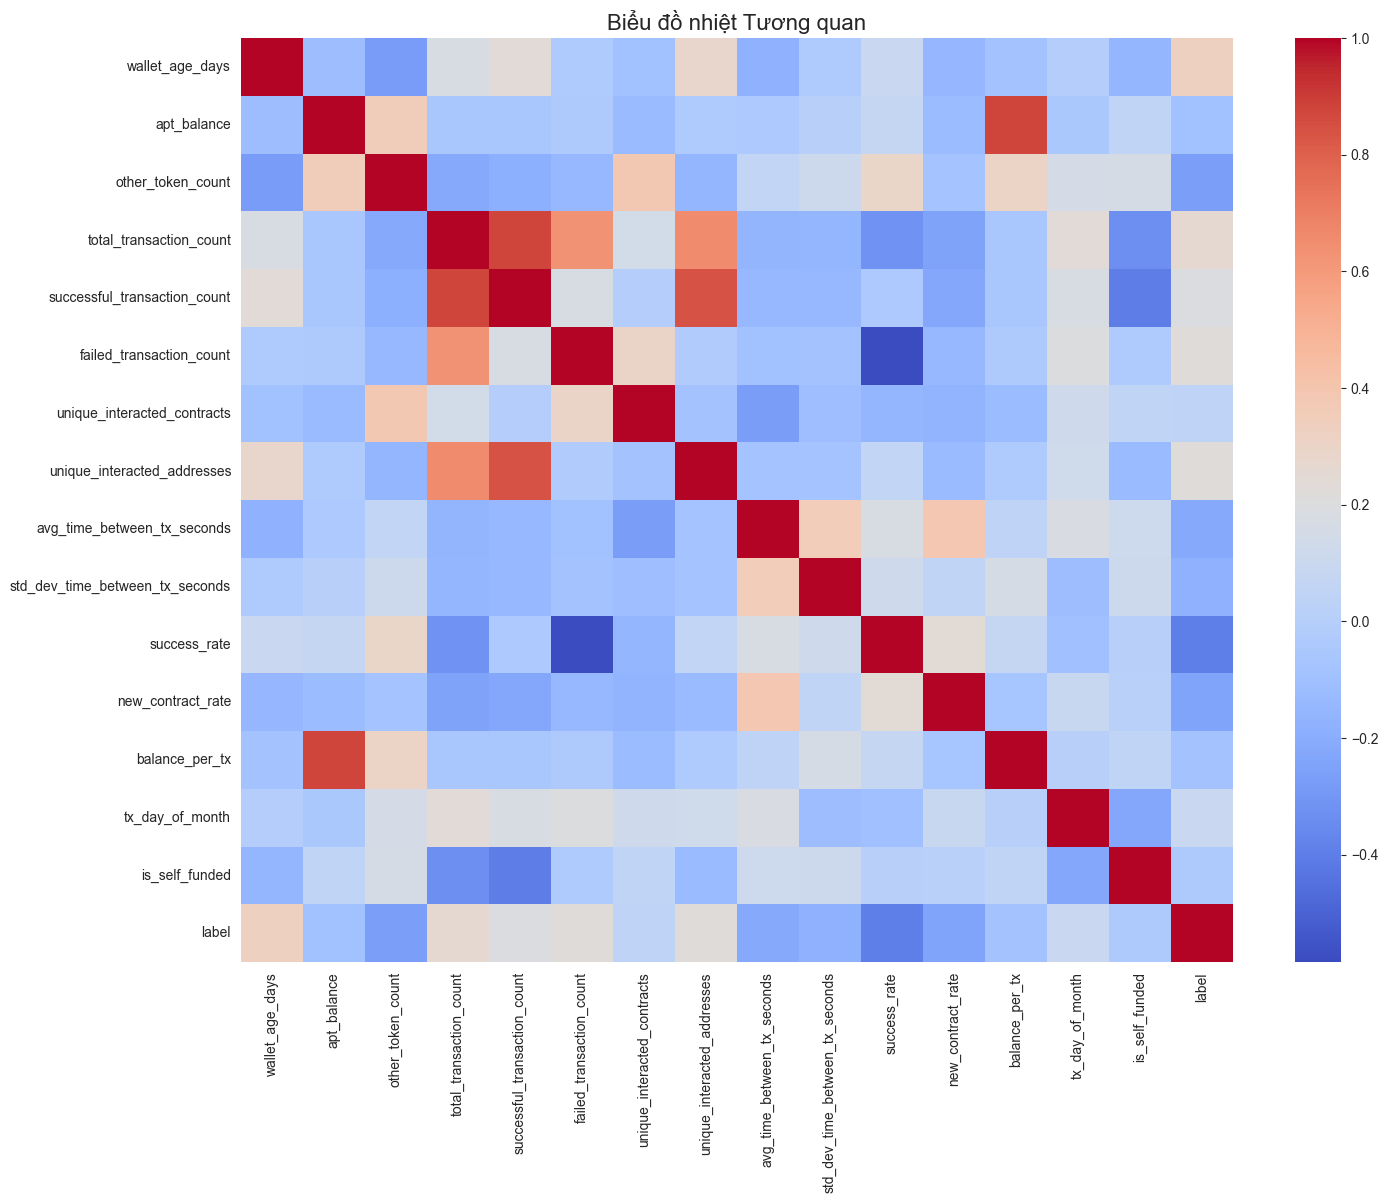


--- So sánh giá trị các đặc trưng giữa 2 lớp (Boxplot) ---


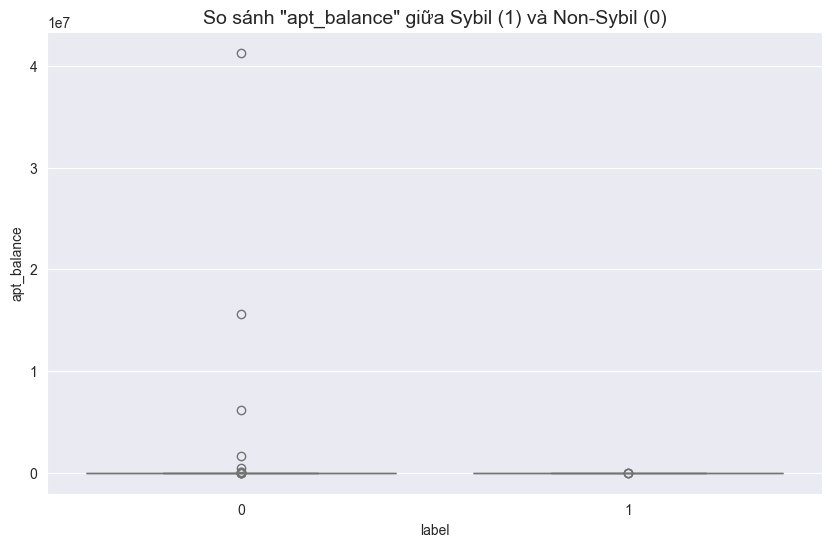

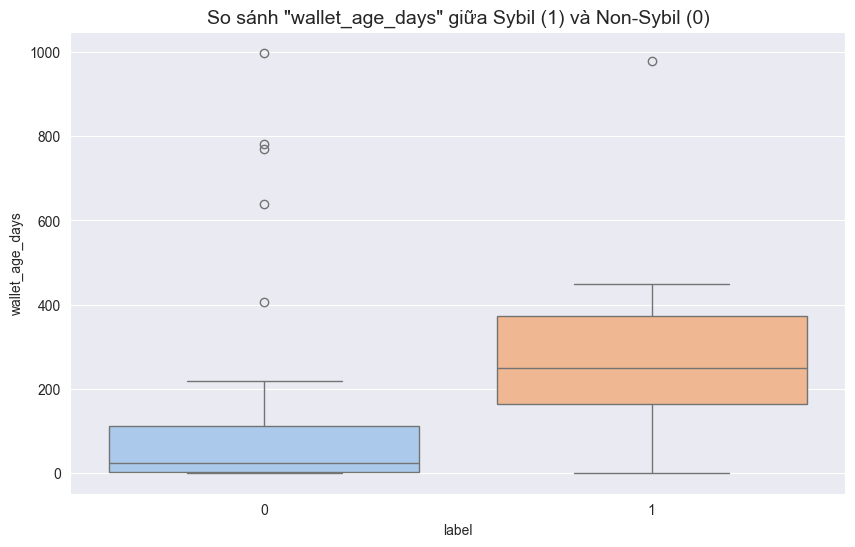

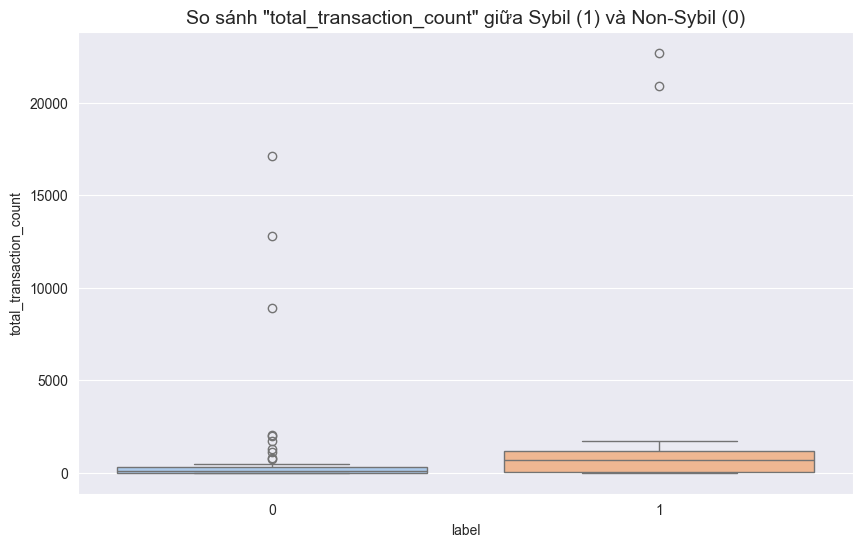

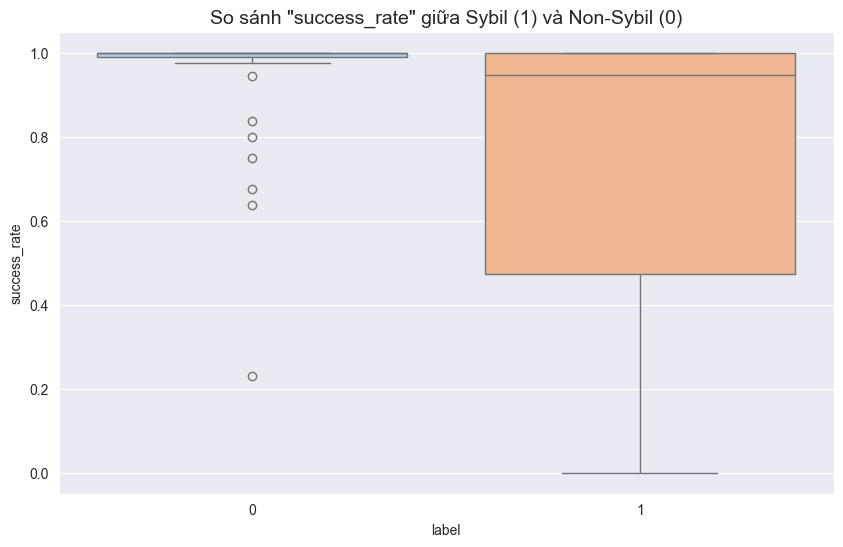

In [3]:
# --- 2.5. Phân tích và Trực quan hóa Dữ liệu (EDA) ---
if not df.empty:
    print("--- 2.5. Bắt đầu Phân tích và Trực quan hóa Dữ liệu (EDA) ---")
    df_eda = df.copy()

    plt.figure(figsize=(16, 12))
    corr_cols = numeric_features + binary_features + ['label']
    correlation_matrix = df_eda[corr_cols].corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
    plt.title('Biểu đồ nhiệt Tương quan', fontsize=16)
    plt.show()

    important_features_to_plot = ['apt_balance', 'wallet_age_days', 'total_transaction_count', 'success_rate']

    print("\n--- So sánh giá trị các đặc trưng giữa 2 lớp (Boxplot) ---")
    for feature in important_features_to_plot:
        if feature in df_eda.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df_eda, x='label', y=feature, hue='label', palette='pastel', legend=False)
            plt.title(f'So sánh "{feature}" giữa Sybil (1) và Non-Sybil (0)', fontsize=14)
            plt.show()

In [4]:
# --- 3. Xây dựng Pipeline Tiền xử lý Nâng cao ---


from sklearn.pipeline import Pipeline

# Pipeline cho các cột dạng số
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline cho các cột dạng hạng mục (categorical)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Hàm và pipeline cho các cột dạng tuần hoàn (cyclical)
def cyclical_encoder(X):
    X_encoded = np.array([])
    max_vals = [23, 6, 12]
    for i in range(X.shape[1]):
        col_data = X[:, i:i+1]
        max_val = max_vals[i]
        X_sin = np.sin(2 * np.pi * col_data / (max_val + 1))
        X_cos = np.cos(2 * np.pi * col_data / (max_val + 1))
        if X_encoded.size == 0:
            X_encoded = np.concatenate([X_sin, X_cos], axis=1)
        else:
            X_encoded = np.concatenate([X_encoded, X_sin, X_cos], axis=1)
    return X_encoded

cyclical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('encoder', FunctionTransformer(cyclical_encoder))
])

# Pipeline cho các cột nhị phân (0/1)
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Kết hợp tất cả các bước xử lý vào một ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('cyc', cyclical_transformer, cyclical_features),
        ('bin', binary_transformer, binary_features)
    ],
    remainder='drop'
)

print("✅ Pipeline tiền xử lý đã được xây dựng (sử dụng sklearn.pipeline).")

✅ Pipeline tiền xử lý đã được xây dựng (sử dụng sklearn.pipeline).


In [5]:
# --- 4. Tinh chỉnh Siêu tham số cho các Mô hình ---
if not df.empty:
    models = {
        "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
        # Dòng đã sửa: Xóa use_label_encoder=False
        "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
    }


    param_grids = {
        "RandomForest": {
            'model__n_estimators': [100, 150, 200, 250],
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        "XGBoost": {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1]
        },
        "LightGBM": {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1]
        }
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_estimators = {}

    print("--- Bắt đầu Tinh chỉnh Siêu tham số ---")
    for model_name in tqdm(models.keys(), desc="Tinh chỉnh các mô hình"):
        print(f"\n--- Đang tinh chỉnh cho: {model_name} ---")
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
            ('smote', SMOTE(random_state=42)),
            ('model', models[model_name])
        ])
        # Giữ nguyên n_iter=10, giờ đã có đủ không gian để chọn
        random_search = RandomizedSearchCV(
            estimator=pipeline, param_distributions=param_grids[model_name],
            n_iter=10, cv=cv, verbose=0, random_state=42, n_jobs=-1, scoring='roc_auc'
        )
        random_search.fit(X, y)
        print(f"AUC tốt nhất: {random_search.best_score_:.4f}")
        best_estimators[model_name] = {'score': random_search.best_score_, 'estimator': random_search.best_estimator_}

    best_model_name = max(best_estimators, key=lambda k: best_estimators[k]['score'])
    final_pipeline = best_estimators[best_model_name]['estimator']
    best_score = best_estimators[best_model_name]['score']
    print(f"\n==> Mô hình tốt nhất: {best_model_name} với AUC là {best_score:.4f}")

--- Bắt đầu Tinh chỉnh Siêu tham số ---


Tinh chỉnh các mô hình:   0%|          | 0/3 [00:00<?, ?it/s]


--- Đang tinh chỉnh cho: RandomForest ---
AUC tốt nhất: 0.8036

--- Đang tinh chỉnh cho: XGBoost ---
AUC tốt nhất: 0.7988

--- Đang tinh chỉnh cho: LightGBM ---
AUC tốt nhất: 0.8412

==> Mô hình tốt nhất: LightGBM với AUC là 0.8412



--- Tạo biểu đồ diễn giải SHAP tổng quan ---


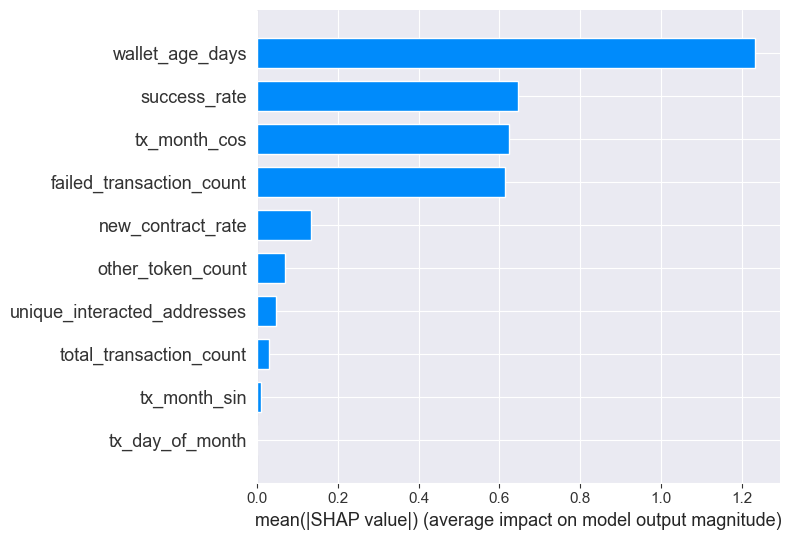

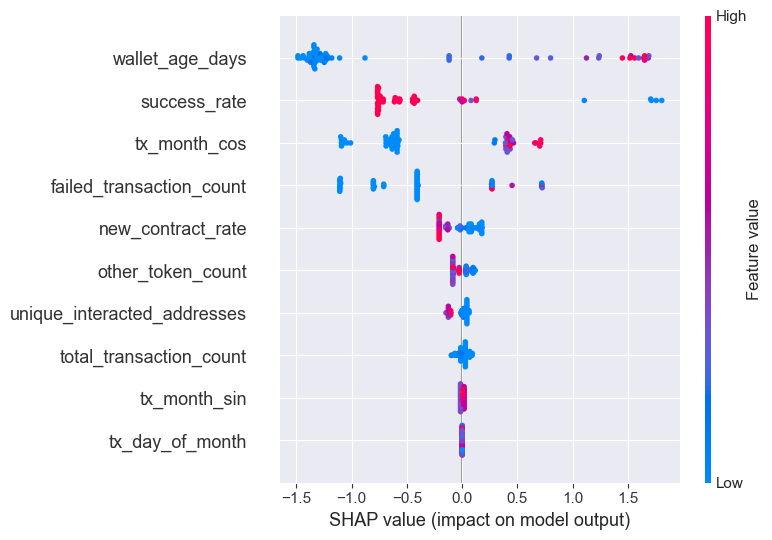

In [6]:
# --- 5. Diễn giải Mô hình cuối cùng với SHAP (Tổng quan) ---
if 'final_pipeline' in locals():
    print("\n--- Tạo biểu đồ diễn giải SHAP tổng quan ---")
    try:
        # Lấy tên đặc trưng sau khi tiền xử lý
        ohe_feature_names = []
        if 'cat' in final_pipeline.named_steps['preprocessor'].named_transformers_ and len(categorical_features) > 0:
            ohe_feature_names = final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
        cyc_feature_names = [f"{f}_{s}" for f in cyclical_features for s in ['sin', 'cos']]
        processed_feature_names = numeric_features + ohe_feature_names + cyc_feature_names + binary_features

        # Lấy dữ liệu đã xử lý và các đặc trưng được chọn
        X_processed = final_pipeline.named_steps['preprocessor'].transform(X)
        feature_selector = final_pipeline.named_steps['feature_selection']
        support_mask = feature_selector.get_support()
        final_feature_names = [name for name, supported in zip(processed_feature_names, support_mask) if supported]
        X_selected = feature_selector.transform(X_processed)
        X_selected_df = pd.DataFrame(X_selected, columns=final_feature_names)

        # Tạo explainer và tính giá trị SHAP
        explainer = shap.TreeExplainer(final_pipeline.named_steps['model'])
        shap_values = explainer.shap_values(X_selected_df)

        # Vẽ biểu đồ
        shap_v_for_plot = shap_values[1] if isinstance(shap_values, list) else shap_values
        shap.summary_plot(shap_v_for_plot, X_selected_df, plot_type="bar", show=True)
        shap.summary_plot(shap_v_for_plot, X_selected_df, show=True)
    except Exception as e:
        print(f"Lỗi khi tạo biểu đồ SHAP: {e}")


--- 5.5. Bắt đầu Đánh giá Mô hình Chuyên sâu ---

--- Ma trận nhầm lẫn ---


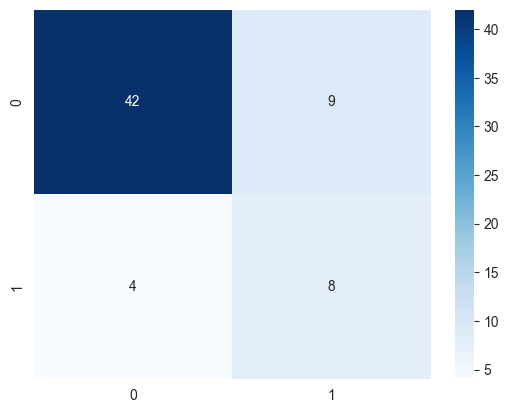


--- Báo cáo phân loại ---
               precision    recall  f1-score   support

Non-Sybil (0)       0.91      0.82      0.87        51
    Sybil (1)       0.47      0.67      0.55        12

     accuracy                           0.79        63
    macro avg       0.69      0.75      0.71        63
 weighted avg       0.83      0.79      0.81        63



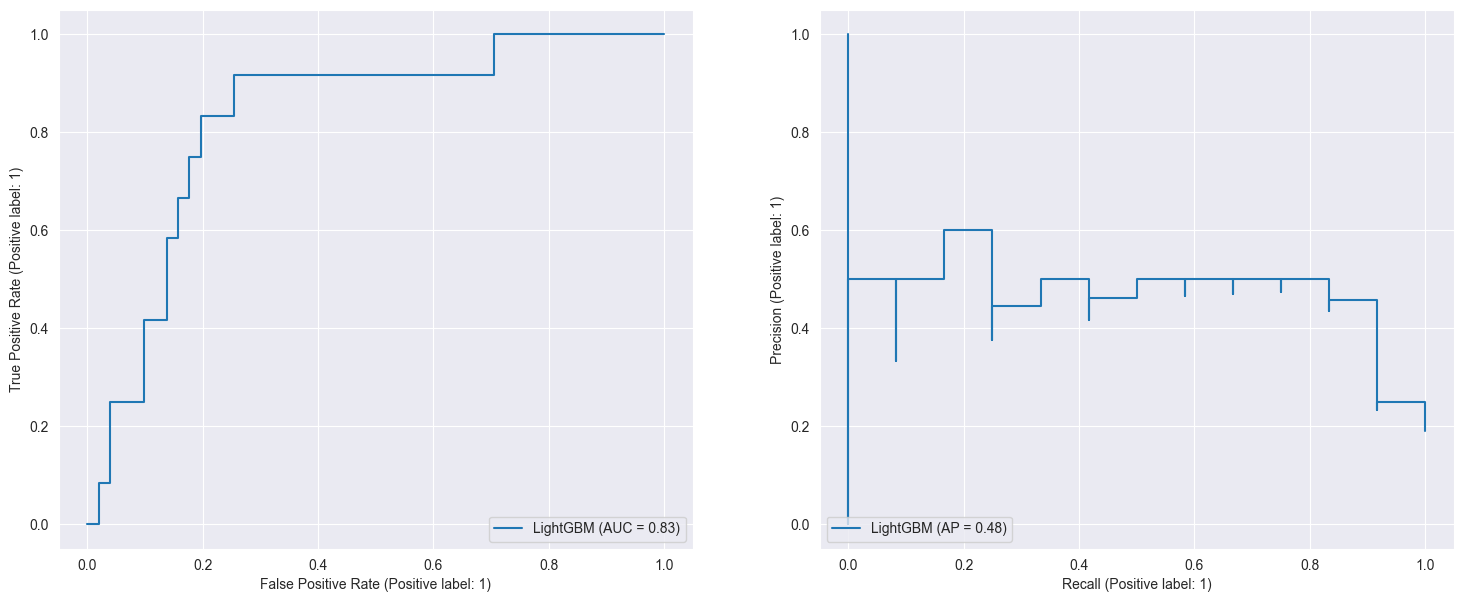

In [7]:
# --- 5.5. Đánh giá Mô hình Chuyên sâu ---
if 'final_pipeline' in locals():
    print("\n--- 5.5. Bắt đầu Đánh giá Mô hình Chuyên sâu ---")
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

    y_pred = cross_val_predict(final_pipeline, X, y, cv=cv)
    y_pred_proba = cross_val_predict(final_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

    print("\n--- Ma trận nhầm lẫn ---")
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

    print("\n--- Báo cáo phân loại ---")
    print(classification_report(y, y_pred, target_names=['Non-Sybil (0)', 'Sybil (1)']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    RocCurveDisplay.from_predictions(y, y_pred_proba, ax=ax1, name=f'{best_model_name}')
    PrecisionRecallDisplay.from_predictions(y, y_pred_proba, ax=ax2, name=f'{best_model_name}')
    plt.show()


--- 5.6. Bắt đầu Diễn giải SHAP Nâng cao ---

--- Biểu đồ phụ thuộc SHAP ---


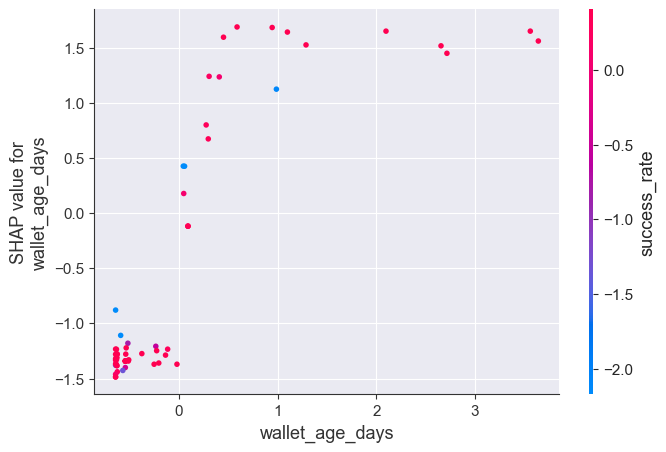

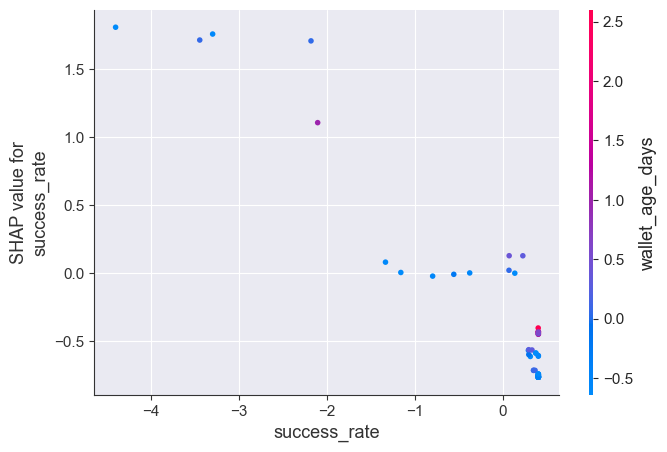

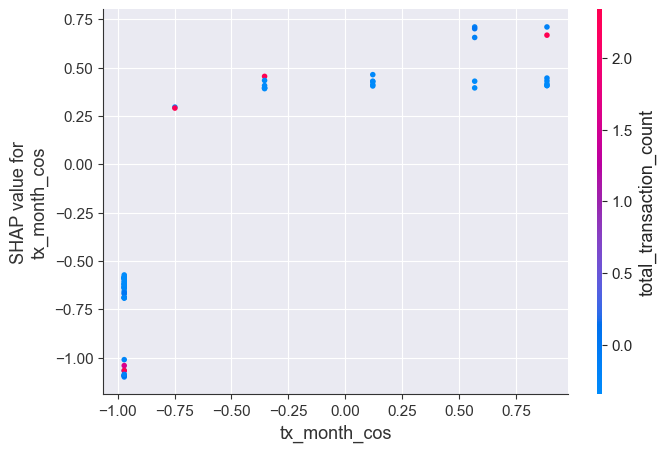

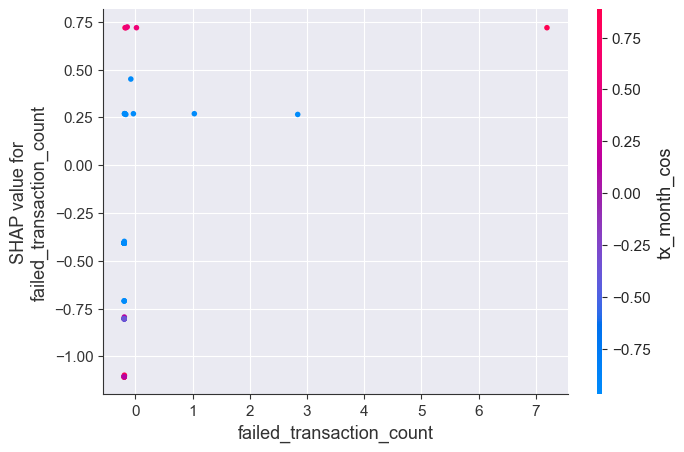


--- Giải thích cho các dự đoán đơn lẻ (Force Plot) ---


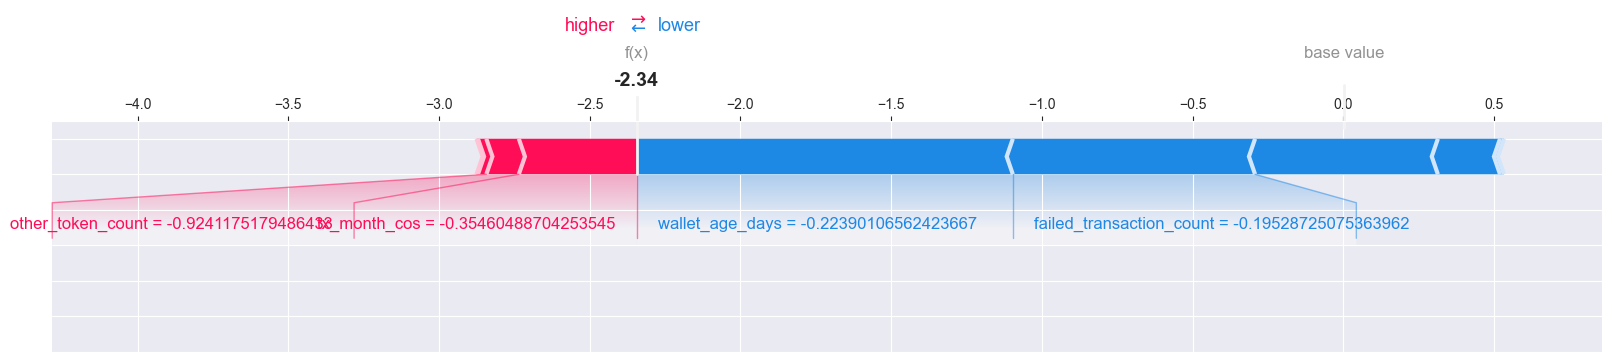

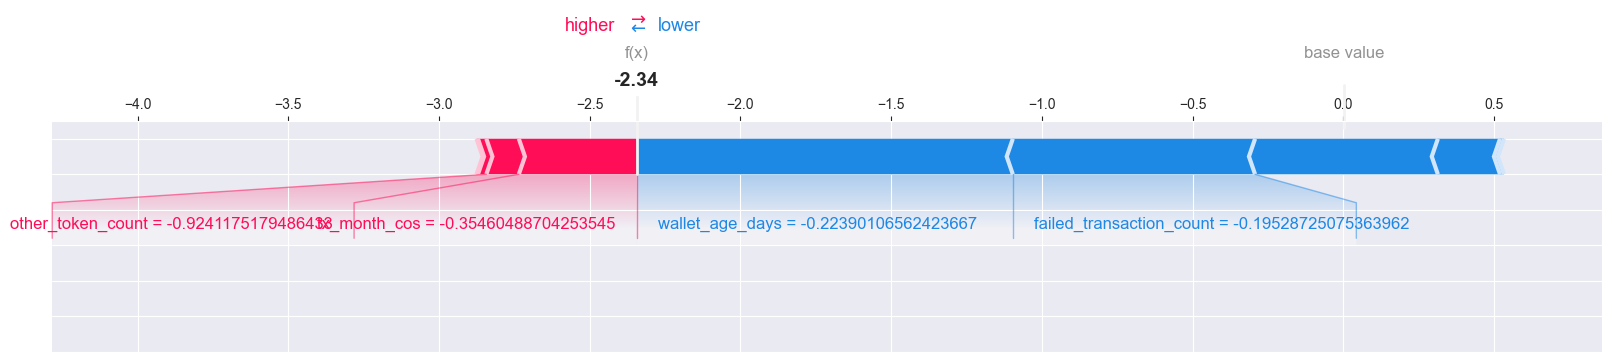

In [8]:
# --- 5.6. Diễn giải SHAP Nâng cao ---
if 'final_pipeline' in locals():
    print("\n--- 5.6. Bắt đầu Diễn giải SHAP Nâng cao ---")
    try:
        # Logic xác định giá trị SHAP và base value đã được kiểm chứng
        shap_v_for_plot = shap_values[1] if isinstance(shap_values, list) else shap_values
        if hasattr(explainer.expected_value, '__len__') and not isinstance(explainer.expected_value, str):
            base_value_for_plot = explainer.expected_value[1]
        else:
            base_value_for_plot = explainer.expected_value

        # Vẽ biểu đồ phụ thuộc (Thường thì dependence_plot không bị lỗi này vì nó dùng Matplotlib)
        print("\n--- Biểu đồ phụ thuộc SHAP ---")
        top_features = X_selected_df.columns[np.argsort(np.abs(shap_v_for_plot).mean(0))][::-1][:4]

        # Chuyển DataFrame thành NumPy array trước khi truyền vào hàm
        X_selected_np = X_selected_df.to_numpy()

        for i, feature_name in enumerate(top_features):
            feature_idx = X_selected_df.columns.get_loc(feature_name)
            shap.dependence_plot(feature_idx, shap_v_for_plot, X_selected_np, feature_names=X_selected_df.columns, interaction_index="auto", show=True)

        # Vẽ force plot
        print("\n--- Giải thích cho các dự đoán đơn lẻ (Force Plot) ---")

        # BỎ LỆNH shap.initjs() Ở ĐÂY VÌ ĐÃ CÓ Ở CELL ĐẦU TIÊN

        sybil_index = np.where(y_pred == 1)[0]
        if len(sybil_index) > 0:
            # SỬA LỖI: Thêm `matplotlib=True` để vẽ biểu đồ bằng Matplotlib,
            # tránh lỗi không tải được JavaScript.
            # `show=False` để tránh plot 2 lần, sau đó dùng plt.show() để hiển thị.
            display(shap.force_plot(base_value_for_plot,
                                    shap_v_for_plot[sybil_index[0],:],
                                    X_selected_df.iloc[sybil_index[0],:],
                                    matplotlib=True,
                                    show=False))
            plt.show() # Hiển thị biểu đồ Matplotlib
        else:
            print("Không tìm thấy dự đoán nào là 'sybil' (1) để vẽ force plot.")

    except Exception as e:
        print(f"❌ Đã xảy ra lỗi không mong muốn trong SHAP nâng cao: {e}")

In [9]:
# --- 6. Lưu Mô hình và Pipeline cuối cùng ---
if 'final_pipeline' in locals():
    output_dir = 'C:/A-A-C/models'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    pipeline_path = os.path.join(output_dir, 'aptos_pro_pipeline.joblib')
    joblib.dump(final_pipeline, pipeline_path)
    print(f"\n✅ Pipeline tối ưu đã được lưu thành công tại: {pipeline_path}")
else:
    print("❌ Không thể lưu vì pipeline chưa được tạo.")


✅ Pipeline tối ưu đã được lưu thành công tại: C:/A-A-C/models\aptos_pro_pipeline.joblib
